# Workspace \#6: ``echo.py``

In [1]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

In [2]:
from random import random

import sys
sys.path.insert(0, '../')

import tools as tl
import constants as ct
import particle as pt
import ska as sk
import astro as ap
import echo as ec

/home/buenabad/anaconda2/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/buenabad/anaconda2/lib/python2.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [3]:
# The contents of echo.py
dir(ec)

['Omega_dispersion',
 'Omega_size',
 'Snu_echo',
 'Snu_source',
 'Tbg_408_antipodal',
 'Tbg_408_avg',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'ap',
 'axion_pref',
 'check_axion',
 'check_data',
 'check_source',
 'ct',
 'dSnu_echo',
 'division',
 'echo_ad_fn',
 'echo_an',
 'echo_an_sup',
 'echo_free_fn',
 'echo_tot_fn',
 'erf',
 'exp',
 'ga_reach',
 'interp1d',
 'lambertw',
 'log',
 'log10',
 'ma_ga_bound',
 'noise',
 'np',
 'nu_array_default',
 'os',
 'pi',
 'power',
 'pref',
 'pt',
 'quad',
 'signal',
 'sk',
 'sn_ratio',
 'snr_fn',
 'sqrt',
 'tl',
 'trapz']

Computing the solid angle from the velocity dispersion:

In [4]:
D = 3.4 # [kpc] Cas A
A = 4.*pi*(D*ct._kpc_over_cm_)**2. # [cm^2] area
SnuCasA = 2723 # [Jy] Cas A

LumCasA = (SnuCasA*ct._Jy_over_cgs_irrad_)*A

source_input = {'longitude':111.734745, # Cas A
                'latitude':-02.129570, # Cas A
                'distance':D, # Cas A
                't_age':330., # Cas A
                'alpha':0.77,
                'nu_pivot':1.,
                'gamma':2.03, # Cas A experiment
                'model':'eff', 'L_today':LumCasA, 'L_peak':1.e30,
#                 't_peak':100,
                't_peak':90,
#                 'size':1.e-6, 'force_Omega_size_compute':False, # fixed size
                'size':1.e-6, 'force_Omega_size_compute':True # forced to compute size; value overruled
               }
Omega_size = ec.Omega_size(source_input)

print(source_input)
print(Omega_size)
print(source_input['size'])
print(ct._casA_solid_angle_)

{'t_peak': 90, 'L_peak': 1e+30, 'alpha': 0.77, 'size': 1e-06, 'distance': 3.4, 'nu_pivot': 1.0, 'force_Omega_size_compute': True, 'longitude': 111.734745, 'latitude': -2.12957, 'L_today': 3.766367905994918e+25, 'model': 'eff', 't_age': 330.0, 'gamma': 2.03}
1e-06
1e-06
1.6614302187698022e-06


In [5]:
D = 3.4 # [kpc] Cas A
A = 4.*pi*(D*ct._kpc_over_cm_)**2. # [cm^2] area
SnuCasA = 2723 # [Jy] Cas A

LumCasA = (SnuCasA*ct._Jy_over_cgs_irrad_)*A

source_input = {'longitude':111.734745, # Cas A
                'latitude':-02.129570, # Cas A
                'distance':D, # Cas A
                't_age':300., # Cas A
                'alpha':0.77,
                'nu_pivot':1.,
                'gamma':2.03, # Cas A experiment
                'model':'eff', 'L_today':LumCasA, 'L_peak':1.e30,
                't_peak':100.,
                'size':1.e-6, 'force_Omega_size_compute':True, # forced to compute size; value 
                'force_Omega_disp_compute':True
               }

data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0
       }

Omega_dispersion, Omega_aberr = ec.Omega_dispersion(source_input, data,
                                                    tmin_default=None,
                                                    xmax_default=100.,
                                                    t_extra_old=0.)

print(Omega_dispersion, Omega_aberr)
print(source_input['Omega_dispersion'], source_input['Omega_aberration'])
print(data)

(8.693359985826577e-07, 3.8640699942038426e-11)
(8.693359985826577e-07, 3.8640699942038426e-11)
{'f_Delta': 0.83848, 'verbose': 0, 'average': True, 'total_observing_time': 100.0, 'DM_profile': 'NFW', 'deltaE_over_E': 0.00145326, 'exper': 'SKA'}


Checking source_input (and computing unknown lightcurve parameters):

In [6]:
D = 3.4 # [kpc] Cas A
A = 4.*pi*(D*ct._kpc_over_cm_)**2. # [cm^2] area
SnuCasA = 2723 # [Jy] Cas A

LumCasA = (SnuCasA*ct._Jy_over_cgs_irrad_)*A

# missing lightcurve parameter: t_trans
source_input = {'longitude':111.734745, # Cas A
                'latitude':-02.129570, # Cas A
                'distance':D, # Cas A
                't_age':300., # Cas A
                'alpha':0.77,
                'nu_pivot':1.,
                'gamma':2.03, # Cas A experiment
                'model':'eff', 'L_today':LumCasA, 'L_peak':1.e30,
                't_peak':100.
               }

ec.check_source(source_input)
print(source_input)
print('now we have t_trans: %s' %(source_input['t_trans']))
ec.check_source(source_input)

{'t_peak': 100.0, 'L_peak': 1e+30, 't_trans': 32.59251578472727, 'alpha': 0.77, 'use_free_expansion': True, 'distance': 3.4, 'nu_pivot': 1.0, 'name': 'custom', 'force_Omega_disp_compute': True, 'longitude': 111.734745, 'latitude': -2.12957, 'L_today': 3.766367905994918e+25, 'model': 'eff', 't_age': 300.0, 'gamma': 2.03}
now we have t_trans: 32.59251578472727


Checking the line of sight integrand

/home/buenabad/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


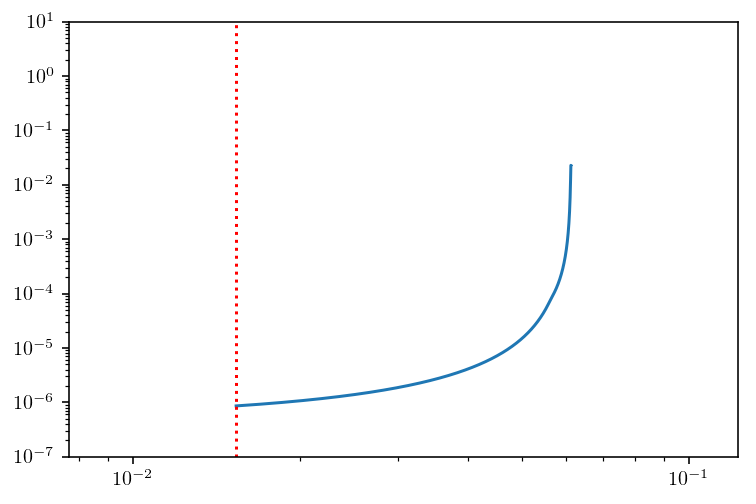

In [7]:
output = {}

D = 3.4 # [kpc] Cas A
A = 4.*pi*(D*ct._kpc_over_cm_)**2. # [cm^2] area
SnuCasA = 2723 # [Jy] Cas A

LumCasA = (SnuCasA*ct._Jy_over_cgs_irrad_)*A

source_input = {'longitude':111.734745, # Cas A
                'latitude':-02.129570, # Cas A
                'distance':D, # Cas A
                't_age':300., # Cas A
                'alpha':0.77,
                'nu_pivot':1.,
                'gamma':2.03, # Cas A experiment
                'model':'eff', 'L_today':LumCasA, 'L_peak':1.e30,
                't_peak':100.
               }

axion_input = {'ma':pt.ma_from_nu(1.),
               'ga':1.e-10
              }
axion_prefactor = ec.axion_pref(axion_input['ma'], axion_input['ga'])

data = {'deltaE_over_E':ct._deltaE_over_E_
       }

t_arr = np.logspace(log10(1./365), log10(source_input['t_age']), 1001)

# computing source
ec.Snu_source(t_arr, 1., source_input, output=output)
tArr, nu, SnuArr = output['source_t-nu-Snu']
Snu_fn = tl.interp_fn(np.vstack((tArr, SnuArr)).T)

theta_echo = pi - ap.theta_gal_ctr(source_input['longitude'], source_input['latitude'], output_radians=True)

t_age = source_input['t_age']
tmin = (source_input['t_peak']/365.)
xmax = min([100., (t_age - tmin)/(2.*ct._kpc_over_lightyear_)])
xmin = ct._au_over_kpc_

# adding extra years
t_extra_old = 100.
x_offset = t_extra_old/(2.*ct._kpc_over_lightyear_)

tage_extended = t_age + t_extra_old
xmax += x_offset
xmin += x_offset

t_lo = tage_extended - 2.*(xmax*ct._kpc_over_lightyear_) # lowest time probed by l.o.s.
t_hi = tage_extended - 2.*(xmin*ct._kpc_over_lightyear_) # highest time probed by l.o.s.
t_arr2 = np.logspace(log10(t_lo), log10(t_hi), 5001) # array of times
xArr = ((t_age - t_arr2)/(2.*ct._kpc_over_lightyear_))[::-1]
xArr += x_offset

dSArr = ec.dSnu_echo(x=xArr,
                     theta=theta_echo,
                     tobs=tage_extended,
                     axion_prefactor=axion_prefactor,
                     Snu_fn=Snu_fn,
                     rho=ap.rho_MW,
                     delE_over_E=data['deltaE_over_E'])

fig_num = int(random()*100)
plt.figure(fig_num)
plt.loglog(xArr, dSArr)
plt.xlim(xmin/2., xmax*2.);
plt.ylim(1.e-7, 10.);
# plt.axvline(ct._au_over_kpc_, c='k', ls=':')
plt.axvline(xmin, c='r', ls=':')

In [8]:
help(ec.Snu_echo)

Help on function Snu_echo in module echo:

Snu_echo(source_input, axion_input, data, recycle_output=(False, None), tmin_default=None, Nt=1001, xmin=4.84810158797031e-09, xmax_default=100.0, use_quad=False, lin_space=False, Nint=50001, t_extra_old=0.0)
    Computes the spectral irradiance (flux density) [Jy] of the echo. Saves to output.
    
    Parameters
    ----------
    source_input : dictionary with source input parameters
    axion_input : dictionary with axion parameters
    data : dictionary with environmental, experimental, and observational data
    recycle_output : whether we recycle a previous computation; and the location where it is stored (default: (False, None))
    tmin_default : the default cutoff minimum time [years] (i.e. the youngest age) of the SNR we will consider (default: None)
    Nt : number of time points over which we interpolate the source's Snu
    xmin : the closest integration distance [kpc] we will consider (default: 1 AU)
    xmax_default : the defau

Computing spectal irradiance echo, comparing different methods

In [9]:
data.update({'verbose':3})
ec.Snu_echo(source_input, axion_input, data,
            recycle_output=(True, output),
            use_quad=True)

print('next')
ec.Snu_echo(source_input, axion_input, data,
            recycle_output=(False, None),
            use_quad=True)

Snu_echo = 5.24e-06, error=1.22e-08

next
Snu_echo = 5.24e-06, error=1.29e-08



5.243349234378247e-06

In [10]:
output

{'echo_Snu': 5.243335162174836e-06,
 'source_t-nu-Snu': (array([2.73972603e-03, 2.77170209e-03, 2.80405136e-03, ...,
         2.93117958e+02, 2.96539015e+02, 3.00000000e+02]),
  1.0,
  array([2.32484679e-54, 1.28937299e-53, 7.00958861e-53, ...,
         2.85435288e+03, 2.78790295e+03, 2.72300000e+03]))}

In [11]:
# varying the various parameters of the ec.Snu_echo function:

print('default: %s'  %(ec.Snu_echo(source_input, axion_input, data,
                              recycle_output=(True, output),
                              tmin_default=None, use_quad=False,
                              lin_space=True, Nint=50001)))

# no recylcing:
print('no recylcing: %s'  %(ec.Snu_echo(source_input, axion_input, data,
                                   recycle_output=(False, None),
                                   tmin_default=None, use_quad=False,
                                   lin_space=True, Nint=50001)))

# less fine grid
print('coarser grid: %s'  %(ec.Snu_echo(source_input, axion_input, data,
                                   recycle_output=(True, output),
                                   tmin_default=None, use_quad=False,
                                   lin_space=True, Nint=5001)))

# smaller tmin (looking deeper into the history of the SN)
print('smaller tmin: %s'  %(ec.Snu_echo(source_input, axion_input, data,
                                   recycle_output=(True, output),
                                   tmin_default=(1./365.), use_quad=False,
                                   lin_space=True, Nint=50001)))

ec.Snu_echo(source_input, axion_input, data,
            recycle_output=(True, output),
            tmin_default=None, use_quad=False,
            lin_space=True, Nint=50001)

pass

default: 5.243325752466716e-06
no recylcing: 5.243340825081711e-06
coarser grid: 5.243346179820121e-06
smaller tmin: 5.759954629475122e-06


### Example: full echo computation

In [12]:
D = 3.4 # [kpc] Cas A
# D = 0.5
A = 4.*pi*(D*ct._kpc_over_cm_)**2. # [cm^2] area
SnuCasA = 2723 # [Jy] Cas A

LumCasA = (SnuCasA*ct._Jy_over_cgs_irrad_)*A

source_input = {'longitude':111.734745, # Cas A
                'latitude':-02.129570, # Cas A
                'distance':D, # Cas A
                't_age':320., # Cas A
                'alpha':0.77,
                'nu_pivot':1.,
                'size':ct._casA_solid_angle_,
                'gamma':2.03, # Cas A experiment
                'model':'eff', 'L_today':LumCasA, 'L_peak':1.e30,
                'size':ct._casA_solid_angle_,
                't_peak':100.
               }

ma_ref, ga_ref = 3.e-6, 1.e-10
axion_input = {'ma':ma_ref,
               'ga':ga_ref
              }
nu_ma = pt.nu_from_ma(ma_ref)

data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'correlation_mode':"interferometry",
        'verbose':0
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':100001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':100001,
                   't_extra_old':0.}
t_arr = np.logspace(log10(t_peak/365.), log10(t_age), 5001)

output = {}
print('Snu of source: %s' %(ec.Snu_source(t_arr, nu_ma, source_input,
                  output=output)))

Snu_echo = ec.Snu_echo(source_input, axion_input, data,
                  recycle_output=(True, output),
                  **Snu_echo_kwargs)

print('Snu_echo: %s' %Snu_echo)

result = ec.signal(source_input, axion_input, data,
                recycle_output=(True, output),
                **Snu_echo_kwargs)
_, _, _, _, _, Psignal = result
print('signal computation result (nu, delnu, Omega, snu_echo, s_echo, power): %s' %(result,))
print('signal power %s' %Psignal)

Snu of source: [1.57860975e+08 1.57860738e+08 1.57860030e+08 ... 5.97982237e+03
 5.96269921e+03 5.94562508e+03]
Snu_echo: 3.183715871802739e-05
signal computation result (nu, delnu, Omega, snu_echo, s_echo, power): (0.36269837676165373, 0.000527095043012641, 1.6614302187698022e-06, 3.183715871802739e-05, 2.68442702071309e-35, 1.2549081037415327e-12)
signal power 1.2549081037415327e-12


In [13]:
source_input

{'L_peak': 1e+30,
 'L_today': 3.766367905994918e+25,
 'Omega_aberration': 4.3969465433296016e-11,
 'Omega_dispersion': 8.708836502416418e-07,
 'alpha': 0.77,
 'distance': 3.4,
 'force_Omega_disp_compute': True,
 'gamma': 2.03,
 'latitude': -2.12957,
 'longitude': 111.734745,
 'model': 'eff',
 'name': 'custom',
 'nu_pivot': 1.0,
 'size': 1.6614302187698022e-06,
 't_age': 320.0,
 't_peak': 100.0,
 't_trans': 41.51946185986438,
 'use_free_expansion': True}

In [14]:
Omdisp_kwargs = {key:value
                 for key, value in Snu_echo_kwargs.items()
                 if key in ['tmin_default', 'xmax_default', 't_extra_old']}

tmp_output = ec.noise(source_input, axion_input, data, recycle_output=(True, output), **Omdisp_kwargs)
print('(nu, delnu, Omega, tbg_408, t_noise, noise power): %s' %(tmp_output,))

(nu, delnu, Omega, tbg_408, t_noise, noise power): (0.36269837676165373, 0.000527095043012641, 1.6614302187698022e-06, 1.6614302187698022e-06, array(69.87706757), 120.06135212563396, array(2.20028789e-12))


In [15]:
help(ec.sn_ratio)

Help on function sn_ratio in module echo:

sn_ratio(signal_power, noise_power, output=None, verbose=0)
    Returns the signal-to-noise ratio.
    
    Parameters
    ----------
    signal_power : power of signal [eV^2]
    noise_power : power of noise [eV^2]
    output : output dictionary (default: None)
    verbose : verbosity (default: 0)



In [16]:
signal_power = output['signal_power']
noise_power = output['noise_power']

print('S/N: %s' %(ec.sn_ratio(signal_power, noise_power, output=output)))

S/N: 0.57033814065988


In [17]:
print(source_input['Omega_dispersion'], output['signal_Omega'], output['noise_Omega_res'], output['noise_Omega_obs'])
print(signal_power, Psignal, noise_power)
print(output['S/N'])

(8.708836502416418e-07, 1.6614302187698022e-06, 1.6614302187698022e-06, 1.6614302187698022e-06)
(1.2549081037415327e-12, 1.2549081037415327e-12, array(2.20028789e-12))
0.57033814065988


In [18]:
help(sk.SKA_specs)

Help on function SKA_specs in module ska:

SKA_specs(nu, exper_mode, eta=0.8, correlation_mode=None, theta_sig=None)
    Returns the specifications (area [m^2], window, receiver noise brightness temperature [K], and solid angle resolution [sr], number_of_dishes, number_of_measurements) of the SKA experiment mode, for the given frequency [GHz].
    
    Parameters
    ----------
    nu : frequency [GHz]
    exper_mode : mode in which the experiment is working
    eta: the detector efficiency (default: 0.8)
    correlation_mode: whether to run in interferometry mode or single dish mode. Default None is meant to raise error if not assigned explicitly.
    theta_sig: the signal size we want to observe [radian]



In [19]:
# yet another way to compute S/N ratio:

delnu = nu_ma * data['deltaE_over_E']

exper_mode = sk.SKA_exper_nu(nu)
_, _, Tr, Omega_res, _, _ = sk.SKA_specs(nu_ma, exper_mode, correlation_mode="interferometry", theta_sig=source_input["size"])

Tbg_408 = ap.bg_408_temp(l=(180.+source_input['longitude']), b=-source_input['latitude'], size=output['noise_Omega_obs'], average=True)
Tnoise = ap.T_noise(nu_ma, Tbg_at_408=Tbg_408, Tr=Tr)
Pnoise = ap.P_noise(Tnoise, delnu, 100., output['noise_Omega_obs'], output['noise_Omega_res'], nu, correlation_mode="interferometry")

print(Tbg_408, Tnoise, Pnoise)
print(Psignal/Pnoise)

(array(69.87706757), 120.06135212563396, array(1.50117807e-12))
0.8359488660403376


Comparing with analytic computation:

In [20]:
Lpk, tpk, dist, L0, tage, gam = source_input['L_peak'], source_input['t_peak'], source_input['distance'], source_input['L_today'], source_input['t_age'], source_input['gamma']

# frequency factor
fac = (nu_ma/source_input['nu_pivot'])**(-source_input['alpha'])
# frequency correction
Lpk *= fac
L0 *= fac
# spectral irradiance today
S0 = ap.irrad(dist, L0)

ftpk = (tpk/365.)/tage # fractional peak time
sup = L0/Lpk # fractional suppression
ftt = ap.ftt(gam, ftpk, L0/Lpk) # fractional transition time

print('ftpk:'+str(ftpk)+'\n'+'ftt:'+str(ftt))

Snu_echo_an = ec.echo_an_sup(ma_ref, ga_ref,
                             Lpk, dist, S0,
                             tage, gam, tpk,
                             deltaE_over_E=data['deltaE_over_E'])
Omega_obs = output['noise_Omega_obs']
print(Omega_obs)

# snr_fn(Secho, nu, delta_nu, Omega_obs=1.e-4, Tbg_408=Tbg_408_avg, eta=ct._eta_ska_, f_Delta=ct._f_Delta_, tobs=100.,  correlation_mode=None, theta_sig=None)

print('numeric:', ec.snr_fn(Snu_echo, nu_ma, nu_ma*data['deltaE_over_E'], Omega_obs=Omega_obs, Tbg_408=Tbg_408, correlation_mode="interferometry", theta_sig=ct.solid_angle_to_angle(source_input["size"])))
print('analytic:', ec.snr_fn(Snu_echo_an, nu_ma, nu_ma*data['deltaE_over_E'], Omega_obs=Omega_obs, Tbg_408=Tbg_408, correlation_mode="interferometry", theta_sig=ct.solid_angle_to_angle(source_input["size"])))

ftpk:0.000856164383562
ftt:0.12974831831207614
1.6614302187698022e-06
('numeric:', 0.57033814065988)
('analytic:', 0.5684006280863774)
